In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from PIL import Image
import os

def resizeImage(infile, file, output_dir, size=(4288, 2848)):
    outfile = os.path.splitext(file)[0]
    extension = os.path.splitext(file)[1]

    if infile != outfile:
        try:
            im = Image.open(infile)
            gray = im.convert('L')
            bw = gray.point(lambda x: 0 if x < 50 else 255, '1')
            bw.save(os.path.join(output_dir, outfile[:-3] + extension), "TIFF")
        except Exception as e:
            print(e)

output_dir = "/content/drive/MyDrive/data/annotations/"
annot_dir = "/content/drive/MyDrive/data/masks"
dir = os.getcwd()

if not os.path.exists(os.path.join(dir, output_dir)):
    os.mkdir(output_dir)

annot = os.path.join(dir, annot_dir)
for file in os.listdir(annot):
    resizeImage(os.path.join(annot, file), file, output_dir)


In [3]:
import os, sys
import numpy as np
import cv2
from matplotlib import pyplot as plt

dir = os.getcwd()
dir_data = os.path.join(dir,"/content/drive/MyDrive/data/Images/")
output_dir_data = os.path.join(dir,"/content/drive/MyDrive/data/images/")
if not os.path.exists(os.path.join(dir,output_dir_data)):
    os.mkdir(output_dir_data)

gridsize = 8
for file in os.listdir(dir_data):
    bgr = cv2.imread(os.path.join(dir_data, file))
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = list(cv2.split(lab))  # Convert tuple to list

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(gridsize, gridsize))

    # Apply CLAHE to the L channel (lab_planes[0])
    lab_planes[0] = clahe.apply(lab_planes[0])

    # Merge the modified LAB channels
    lab = cv2.merge(lab_planes)

    # Convert LAB back to BGR
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    cv2.imwrite(os.path.join(output_dir_data, file), bgr)


In [5]:
import os
import cv2
import numpy as np
import albumentations as A

def extract_and_save_patches(image_path, mask_path, patch_size=512, stride=256, threshold=0.1, num_augmentations=3):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    height, width = image.shape[:2]

    # Define augmentation transformations using Albumentations
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),  # Randomly flip horizontally with a probability of 0.5
        A.Rotate(limit=30, p=0.5),  # Randomly rotate the patch up to 30 degrees
        A.RandomBrightnessContrast(p=0.5),  # Random brightness/contrast adjustments
        # Add more augmentations as needed
    ])

    patch_count = 0

    for _ in range(num_augmentations):
        for y in range(0, height - patch_size + 1, stride):
            for x in range(0, width - patch_size + 1, stride):
                aug_image = image[y:y+patch_size, x:x+patch_size]
                aug_mask = mask[y:y+patch_size, x:x+patch_size]

                # Apply Albumentations transformation
                augmented = transform(image=aug_image, mask=aug_mask)
                aug_image = augmented['image']
                aug_mask = augmented['mask']

                # Check if the patch contains relevant information
                if (aug_mask > 0).sum() / (patch_size * patch_size) > threshold:
                    # Save the patches and masks
                    patch_name = f"patch_{patch_count}.jpg"
                    mask_name = f"mask_{patch_count}.jpg"

                    patch_save_path = os.path.join('/content/drive/MyDrive/data/patches', patch_name)
                    mask_save_path = os.path.join('/content/drive/MyDrive/data/labels', mask_name)

                    # Check and create directories if they don't exist
                    if not os.path.exists('/content/drive/MyDrive/data/patches'):
                        os.makedirs('/content/drive/MyDrive/data/patches')
                    if not os.path.exists('/content/drive/MyDrive/data/labels'):
                        os.makedirs('/content/drive/MyDrive/data/labels')

                    cv2.imwrite(patch_save_path, aug_image)
                    cv2.imwrite(mask_save_path, aug_mask)

                    patch_count += 1

# Directory paths for images and masks
images_dir = '/content/drive/MyDrive/data/images'
masks_dir = '/content/drive/MyDrive/data/annotations'

# Get a list of all image files
image_files = os.listdir(images_dir)
mask_files = os.listdir(masks_dir)

# Ensure the lists are sorted for proper matching of images and masks
image_files.sort()
mask_files.sort()

# Iterate through each image-mask pair and extract patches
for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(images_dir, image_file)
    mask_path = os.path.join(masks_dir, mask_file)

    extract_and_save_patches(image_path, mask_path)


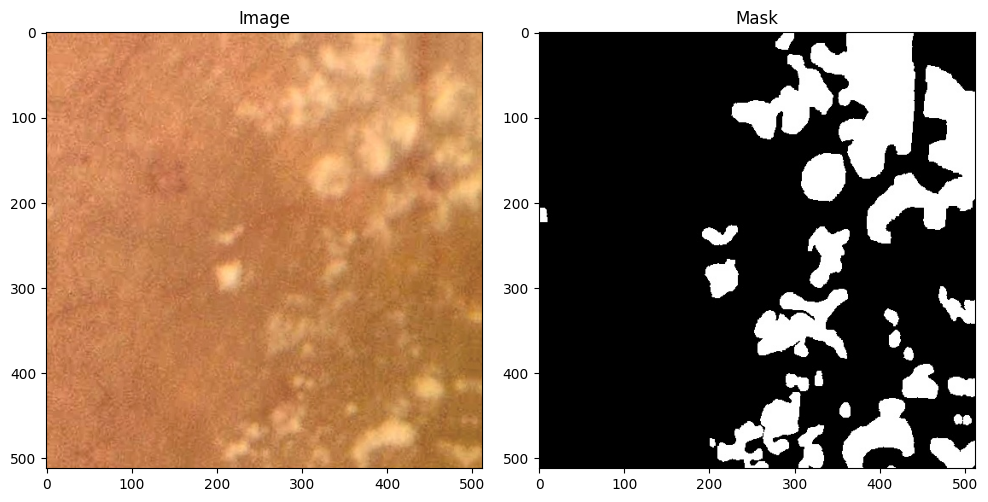

In [3]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to load images from directory and convert to numpy arrays
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return np.array(images)

# Load images and masks
patches_dir = '/content/drive/MyDrive/data/patches'
labels_dir = '/content/drive/MyDrive/data/labels'

patches = load_images_from_folder(patches_dir)
labels = load_images_from_folder(labels_dir)

# Choose a random index
random_index = random.randint(0, len(patches) - 1)

# Display the image and its corresponding mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(cv2.cvtColor(patches[random_index], cv2.COLOR_BGR2RGB))
axes[0].set_title('Image')

axes[1].imshow(labels[random_index], cmap='gray')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()


In [4]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

patches_dir = '/content/drive/MyDrive/data/patches/'
labels_dir = '/content/drive/MyDrive/data/labels/'

SIZE = 512
image_dataset = []
mask_dataset = []

patch_files = os.listdir(patches_dir)
for patch_name in patch_files:
    if patch_name.endswith('.jpg'):
        patch_path = os.path.join(patches_dir, patch_name)
        image = cv2.imread(patch_path)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

        mask_name = f"mask_{patch_name.split('_')[1]}"
        mask_path = os.path.join(labels_dir, mask_name)
        mask = cv2.imread(mask_path, 0)
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask_dataset.append(np.array(mask))

image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1), 3)
mask_dataset = np.expand_dims((np.array(mask_dataset)), 3) / 255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.10, random_state=0)


In [5]:
print("Size of X_train:", len(X_train))
print("Size of X_test:", len(X_test))
print("Size of y_train:", len(y_train))
print("Size of y_test:", len(y_test))

Size of X_train: 122
Size of X_test: 14
Size of y_train: 122
Size of y_test: 14


In [6]:
# Reshape the input data to remove the extra dimension
X_train = X_train.reshape(-1, 512, 512, 3)
X_test = X_test.reshape(-1, 512, 512, 3)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (122, 512, 512, 3)
y_train shape: (122, 512, 512, 1)


In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 512, 512, 16)         448       ['input_5[0][0]']             
                                                                                                  
 dropout_36 (Dropout)        (None, 512, 512, 16)         0         ['conv2d_76[0][0]']           
                                                                                                  
 conv2d_77 (Conv2D)          (None, 512, 512, 16)         2320      ['dropout_36[0][0]']          
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 228ms/step - loss: 0.1656 - accuracy: 0.9027
Accuracy =  90.26876091957092 %


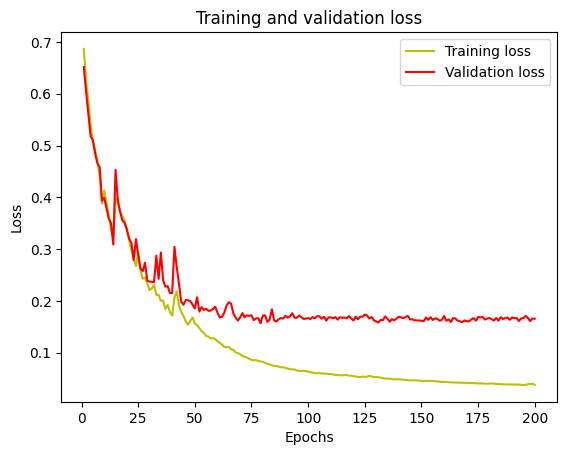

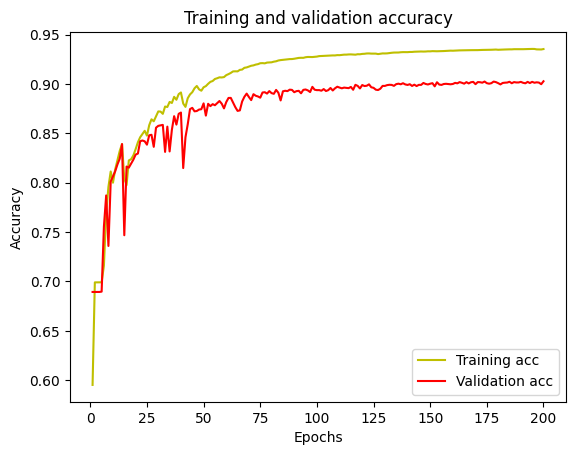

In [23]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from matplotlib import pyplot as plt

IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
# Model Creation using your defined architecture
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

# Save the trained model
model.save('segm_model_ex.h5')

# Model Evaluation
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", acc * 100.0, "%")

# Plotting the training and validation accuracy and loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [24]:
##################################
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 0s 297ms/step
IoU socre is:  0.7915318835207038


1/1 [==============================] - 0s 247ms/step


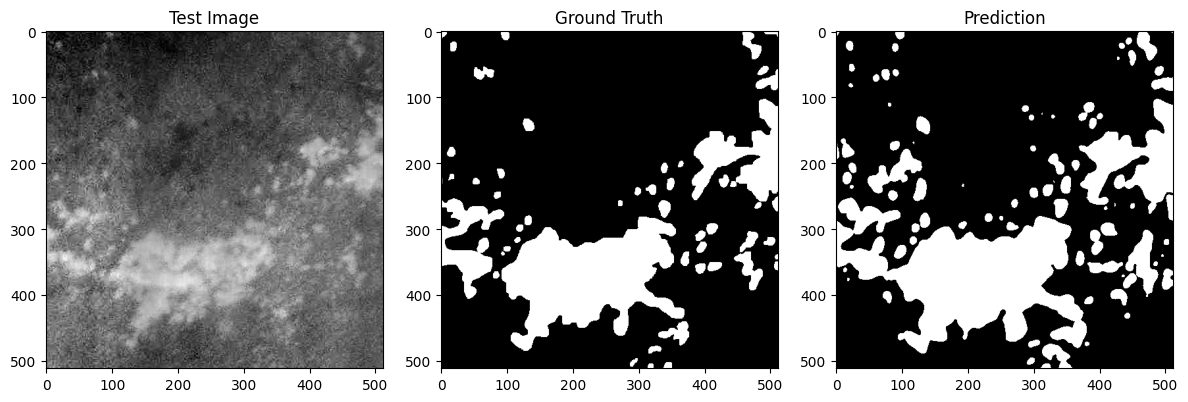

In [44]:
# Load the model
model = load_model('/content/segm_model_ex.h5')

# Assuming you have test data 'X_test' and ground truth 'y_test'
# Assuming you want to predict on a single test image
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]


# Convert the single-channel image to a 3-channel image
test_img_input = np.repeat(test_img[:, :, 0][:, :, np.newaxis], 3, axis=-1)

# Expand the dimensions to match the model input shape
test_img_input = np.expand_dims(test_img_input, axis=0)

# Make predictions on the modified test image
prediction = (model.predict(test_img_input) > 0.2).astype(np.uint8)

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.title('Test Image')
plt.imshow(test_img[:, :, 0], cmap='gray')

plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(ground_truth[:, :, 0], cmap='gray')

plt.subplot(133)
plt.title('Prediction')
plt.imshow(prediction[0, :, :, 0], cmap='gray')

plt.tight_layout()
plt.show()
